# Práctica 1: PCA + Clustering 
* Autores: Luis Bueno y Yago Tobio 
* Dataset original: [Aircraft Wildlife Strikes 1990 - 2023 ](https://www.kaggle.com/datasets/dianaddx/aircraft-wildlife-strikes-1990-2023?resource=download)

---

# 1. Preprocesamiento para purificar el dataset

In [58]:
# * Librerías 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
# Define la ruta del archivo Excel
ruta_archivo = 'STRIKE_REPORTS.csv'

# Carga el archivo Excel en un DataFrame de pandas
df = pd.read_csv(ruta_archivo)

/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_18399/1240123147.py:5: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)


In [3]:
df.head()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,6/22/1996,6,1996,NaN,NaN,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,6/26/1996,6,1996,NaN,NaN,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,7/1/1996,7,1996,NaN,NaN,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,7/1/1996,7,1996,NaN,NaN,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,7/1/1996,7,1996,NaN,NaN,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False


In [4]:

# * Seleccionamos las categorías que deseamos conservar en nuestro dataset
CATEGORICAL_COLUMNS = ['TIME_OF_DAY', 'AIRCRAFT', 'AC_MASS', 'PHASE_OF_FLIGHT', 'SPECIES', 'STATE', 'NUM_STRUCK'] 
NUMERICAL_COLUMNS = ['INCIDENT_YEAR', 'HEIGHT', 'SPEED', 'DISTANCE', 'COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ']
TOTAL_COLUMNS = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS

In [5]:

# *  Elimina filas donde cualquiera de las columnas especificadas tenga un valor NaN
df = df.dropna(subset=['HEIGHT', 'SPEED', 'DISTANCE', 'NUM_STRUCK'])

# * Seleccionamos únicamente las columnas deseadas para nuestro analisis, PCA y Clustering
df = df[TOTAL_COLUMNS]
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ
5,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0.0,100.0,0.0,NaN,NaN
11,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0.0,100.0,0.0,NaN,NaN
13,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0.0,120.0,0.0,NaN,NaN
16,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0.0,125.0,0.0,NaN,NaN
18,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0.0,140.0,0.0,NaN,NaN


Debido al voluminoso tamaño de nuestro conjunto de datos original, consideramos que es una práctica recomendable almacenar los datos ya depurados que emplearemos a lo largo del proyecto en un nuevo archivo con formato .xlsx

In [6]:
# Nombre del archivo de salida
nombre_archivo_salida = 'datos_limpios.xlsx'
df.to_excel(nombre_archivo_salida, index=False)

In [7]:
# Define la ruta del archivo Excel
ruta_archivo = 'datos_limpios.xlsx'

# Carga el archivo Excel en un DataFrame de pandas
df = pd.read_excel(ruta_archivo)
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_REPAIRS_INFL_ADJ,COST_OTHER_INFL_ADJ
0,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,NaN,NaN
1,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,NaN,NaN
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,NaN,NaN
3,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,NaN,NaN
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,NaN,NaN


In [8]:

# Assuming df is your DataFrame
# Convert 'COST_REPAIRS_INFL_ADJ' and 'COST_OTHER_INFL_ADJ' from string to numeric, removing commas
df['COST_REPAIRS_INFL_ADJ'] = pd.to_numeric(df['COST_REPAIRS_INFL_ADJ'].str.replace(',', ''), errors='coerce')
df['COST_OTHER_INFL_ADJ'] = pd.to_numeric(df['COST_OTHER_INFL_ADJ'].str.replace(',', ''), errors='coerce')

# Now, you can safely add these columns
df['COST_INFL_ADJ'] = df['COST_REPAIRS_INFL_ADJ'] + df['COST_OTHER_INFL_ADJ']
# Check the result
print(df['COST_INFL_ADJ'].value_counts())

COST_INFL_ADJ
14014.0     3
2510.0      3
8155.0      2
191100.0    2
105000.0    2
           ..
143115.0    1
170375.0    1
57246.0     1
13678.0     1
367.0       1
Name: count, Length: 657, dtype: int64


In [9]:
df = df.drop(columns=['COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ'])
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_INFL_ADJ
0,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,NaN
1,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,NaN
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,NaN
3,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,NaN
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,NaN


# 2.Analisis Explicativo del dataset (EDA): 

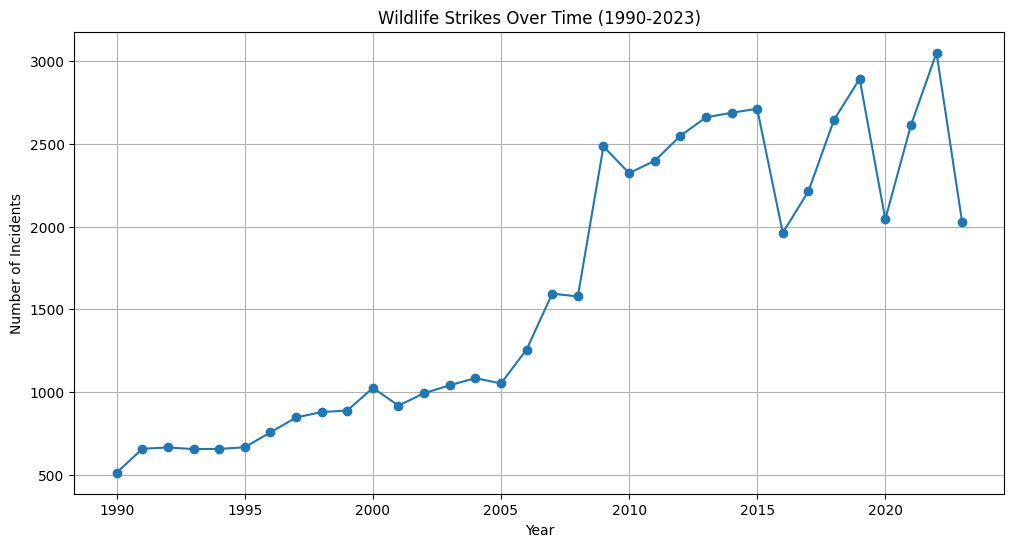

In [10]:
# Assuming df is your DataFrame after loading the dataset
# Plotting incidents over the years
yearly_trends = df.groupby('INCIDENT_YEAR').size()

plt.figure(figsize=(12, 6))
yearly_trends.plot(kind='line', marker='o')
plt.title('Wildlife Strikes Over Time (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()


In [11]:
state_accidents = df.groupby('STATE').size().reset_index(name='counts')
fig = px.choropleth(state_accidents,
                    locations='STATE', 
                    locationmode="USA-states", 
                    color='counts', 
                    color_continuous_scale="Viridis",
                    scope="usa",
                    labels={'counts':'Number of Incidents'}
                   )

fig.update_layout(title_text='Wildlife Strikes by State in the USA (1990-2023)')
fig.show()

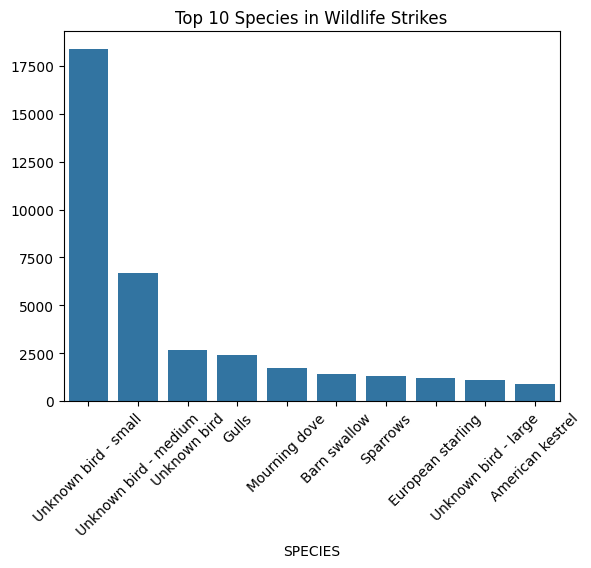

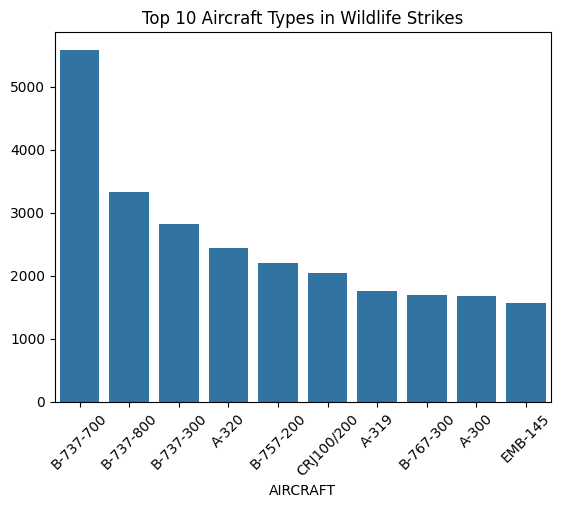

In [12]:
# Top 5 species involved in strikes
top_species = df['SPECIES'].value_counts().head(10)
sns.barplot(x=top_species.index, y=top_species.values)
plt.title('Top 10 Species in Wildlife Strikes')
plt.xticks(rotation=45)
plt.show()

# Aircraft types most involved in strikes
top_aircraft = df['AIRCRAFT'].value_counts().head(10)
sns.barplot(x=top_aircraft.index, y=top_aircraft.values)
plt.title('Top 10 Aircraft Types in Wildlife Strikes')
plt.xticks(rotation=45)
plt.show()

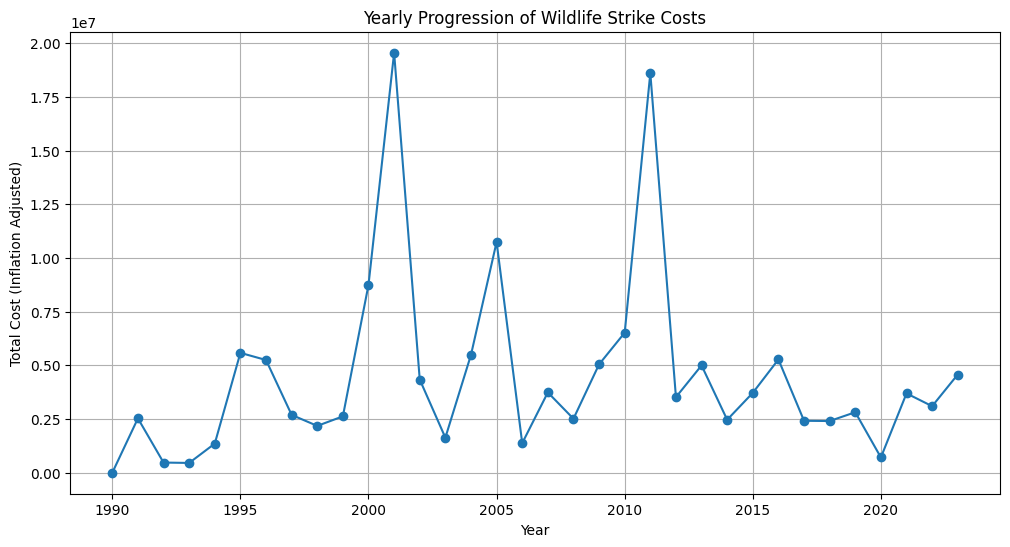

In [13]:
yearly_costs = df.groupby('INCIDENT_YEAR')['COST_INFL_ADJ'].sum()

plt.figure(figsize=(12, 6))
yearly_costs.plot(kind='line', marker='o')
plt.title('Yearly Progression of Wildlife Strike Costs')
plt.xlabel('Year')
plt.ylabel('Total Cost (Inflation Adjusted)')
plt.grid(True)
plt.show()

In [14]:
overall_cost = df['COST_INFL_ADJ'].sum()
print(f"Overall cost (Inflation Adjusted): {overall_cost}")

Overall cost (Inflation Adjusted): 151117411.0


That's $151M gone in damages caused by birds... Let that sink in. 

In [15]:
CATEGORICAL_COLUMNS = ['TIME_OF_DAY', 'AIRCRAFT', 'AC_MASS', 'PHASE_OF_FLIGHT', 'SPECIES', 'NUM_STRUCK']
NUMERICAL_COLUMNS = ['INCIDENT_YEAR', 'HEIGHT', 'SPEED', 'DISTANCE', 'COST_INFL_ADJ']
# Análisis de la distribución de categorías
for i, column in enumerate(CATEGORICAL_COLUMNS, 1): 
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: TIME_OF_DAY
TIME_OF_DAY
Day      33688
Night    14241
Dusk      2575
Dawn      2016
Name: count, dtype: int64


Column: AIRCRAFT
AIRCRAFT
B-737-700                5586
B-737-800                3331
B-737-300                2816
A-320                    2438
B-757-200                2209
                         ... 
F-15E                       1
NORTH AMERICAN              1
CESSNA LC-41                1
BRITISH AEROSPACE           1
NORTH AMERICAN OV-10A       1
Name: count, Length: 453, dtype: int64


Column: AC_MASS
AC_MASS
4.0    37625
3.0     9633
1.0     3572
2.0     3526
5.0      399
Name: count, dtype: int64


Column: PHASE_OF_FLIGHT
PHASE_OF_FLIGHT
Approach        22484
Take-off Run    12474
Landing Roll    11943
Climb            7210
Descent           494
Taxi              151
Local             138
Parked             33
En Route            1
Name: count, dtype: int64


Column: SPECIES
SPECIES
Unknown bird - small     18384
Unknown bird - medium     6704
Unknown bird  

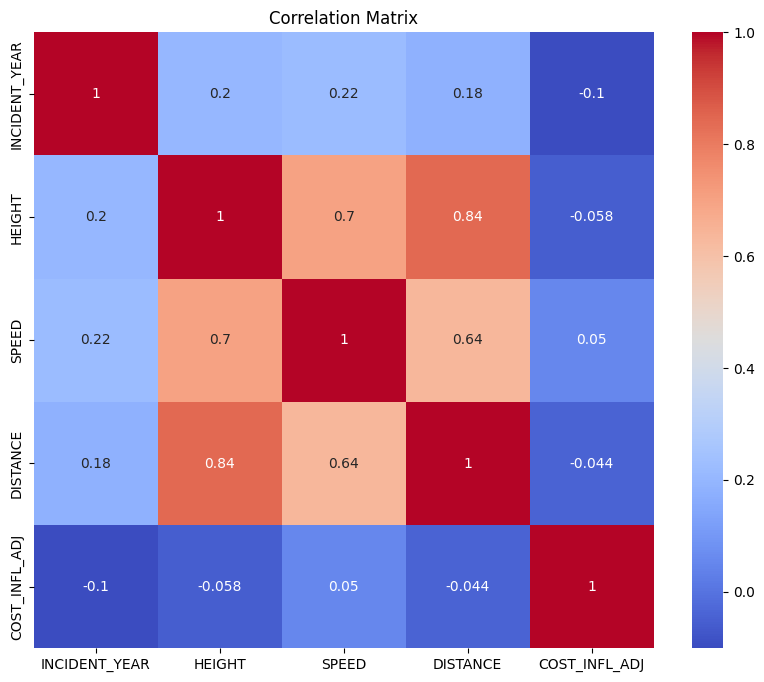

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[NUMERICAL_COLUMNS].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

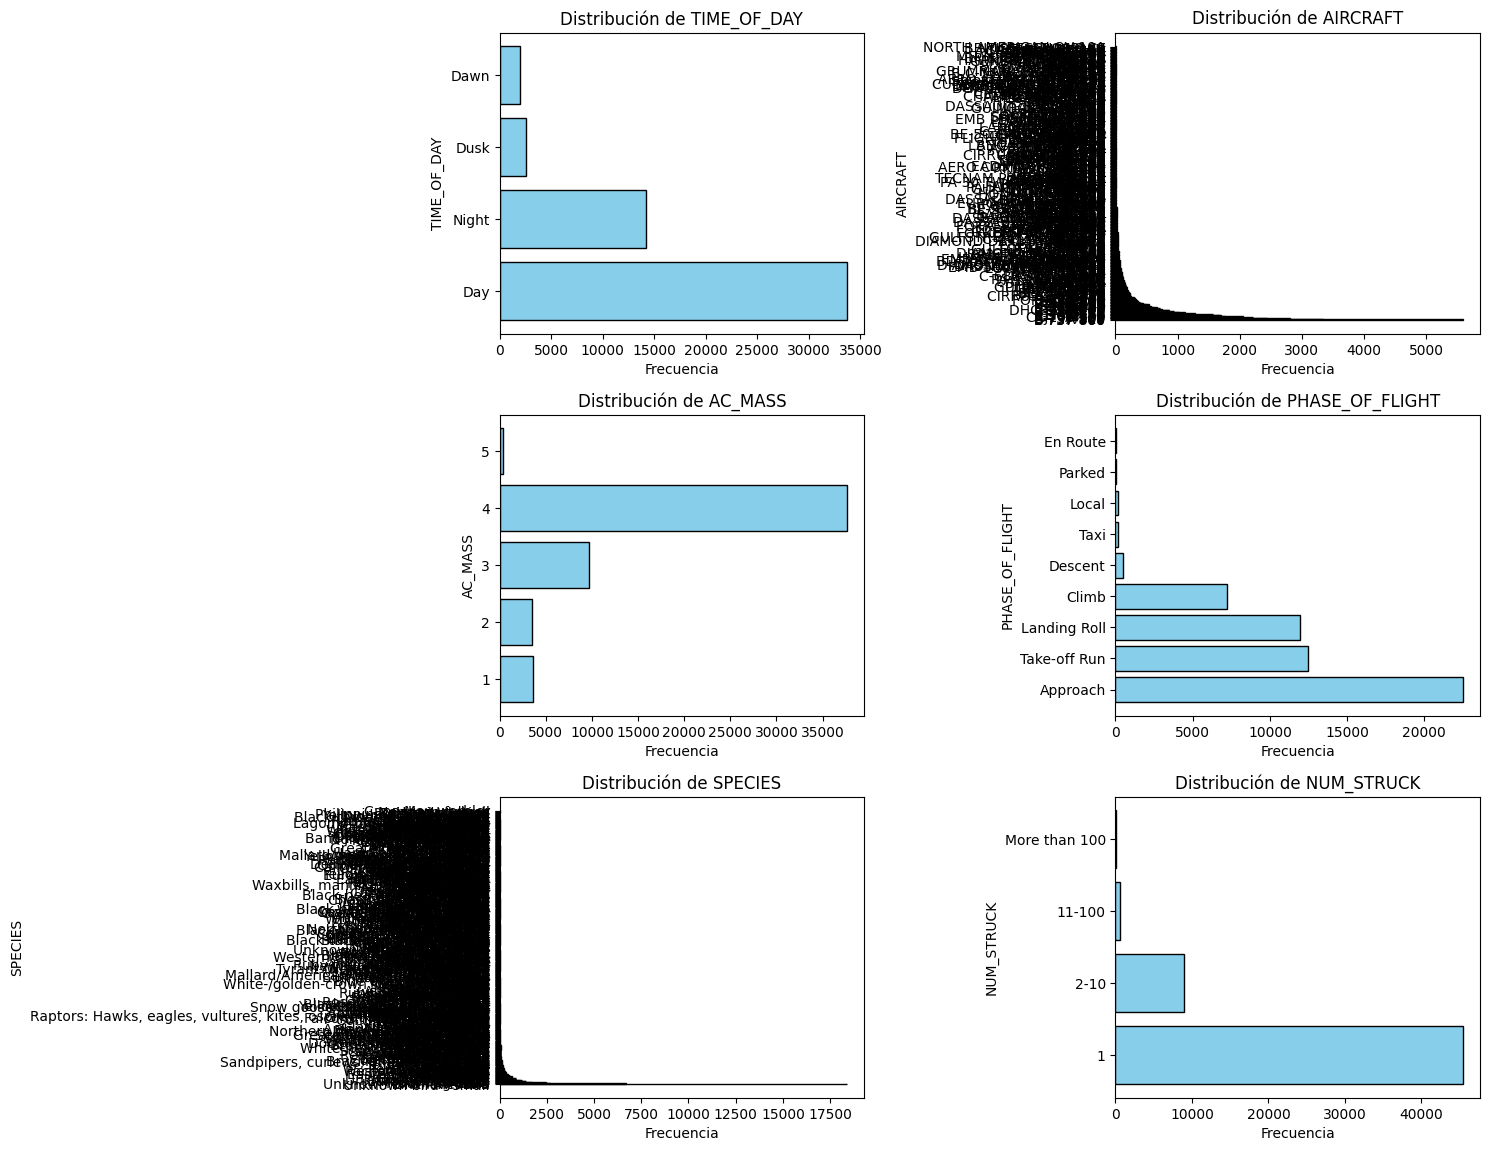

In [17]:

# * Análisis de la distribución de columnas categóricas 
plt.figure(figsize=(15, 15))

for i, column in enumerate(CATEGORICAL_COLUMNS, 1):
    # Calculate the frequencies of each category
    value_counts = df[column].value_counts()
    # Create a horizontal bar chart
    plt.subplot(4, 2, i)  # Adjust the grid dimensions as needed
    plt.barh(value_counts.index, value_counts, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel('Frecuencia')
    plt.ylabel(column)
    
plt.tight_layout()
plt.show()

De las graficas de arriba, podemos observar que existe un gran desfase de clases - particularmente con la columna de SPECIES, AIRPORT_ID y AIRCRAFT. 
Con el fin de equilibrar las clases y seleccionar los datos más relevantes, vamos a generar una tabla la cual cojan datos de hasta el cuartil 75 dentro de toda la distribución y evitar casos extremos. 

Para aquellas otras categorías como AC_MASS, PHASE_OF_FLIGHT, TIME_OF_DAY, procederemos a equilibrar las clases mediante SMOTE. 

----

# Equilibrio de Clases

Debido al gran numero de especies de animal, y aviones ...

In [18]:
# Encontrar las 14 categorías más comunes
top_14_species = df['SPECIES'].value_counts().head(14).index

# Reemplazar todas las otras categorías por 'Other species'
df['SPECIES'] = df['SPECIES'].apply(lambda x: x if x in top_14_species else 'Other species')

# Verificar el resultado
print('DataFrame con categorías agrupadas:')
print(df['SPECIES'].value_counts())


DataFrame con categorías agrupadas:
SPECIES
Unknown bird - small     18384
Other species            14117
Unknown bird - medium     6704
Unknown bird              2647
Gulls                     2428
Mourning dove             1708
Barn swallow              1409
Sparrows                  1316
European starling         1187
Unknown bird - large      1103
American kestrel           867
Killdeer                   858
Rock pigeon                856
Red-tailed hawk            750
Canada goose               662
Name: count, dtype: int64


In [19]:
# Encontrar las 19 categorías más comunes
top_19_aircraft = df['AIRCRAFT'].value_counts().head(19).index

# Reemplazar todas las otras categorías por 'Other species'
df['AIRCRAFT'] = df['AIRCRAFT'].apply(lambda x: x if x in top_19_aircraft else 'Other aircrafts')

# Verificar el resultado
print('DataFrame con categorías agrupadas:')
print(df['AIRCRAFT'].value_counts())

DataFrame con categorías agrupadas:
AIRCRAFT
Other aircrafts    21213
B-737-700           5586
B-737-800           3331
B-737-300           2816
A-320               2438
B-757-200           2209
CRJ100/200          2046
A-319               1755
B-767-300           1700
A-300               1682
EMB-145             1562
EMB-170             1277
MD-82               1118
A-321               1116
C-172               1014
B-717-200            945
B-737-200            859
MD-11                855
DHC8 DASH 8          756
B-727-200            718
Name: count, dtype: int64


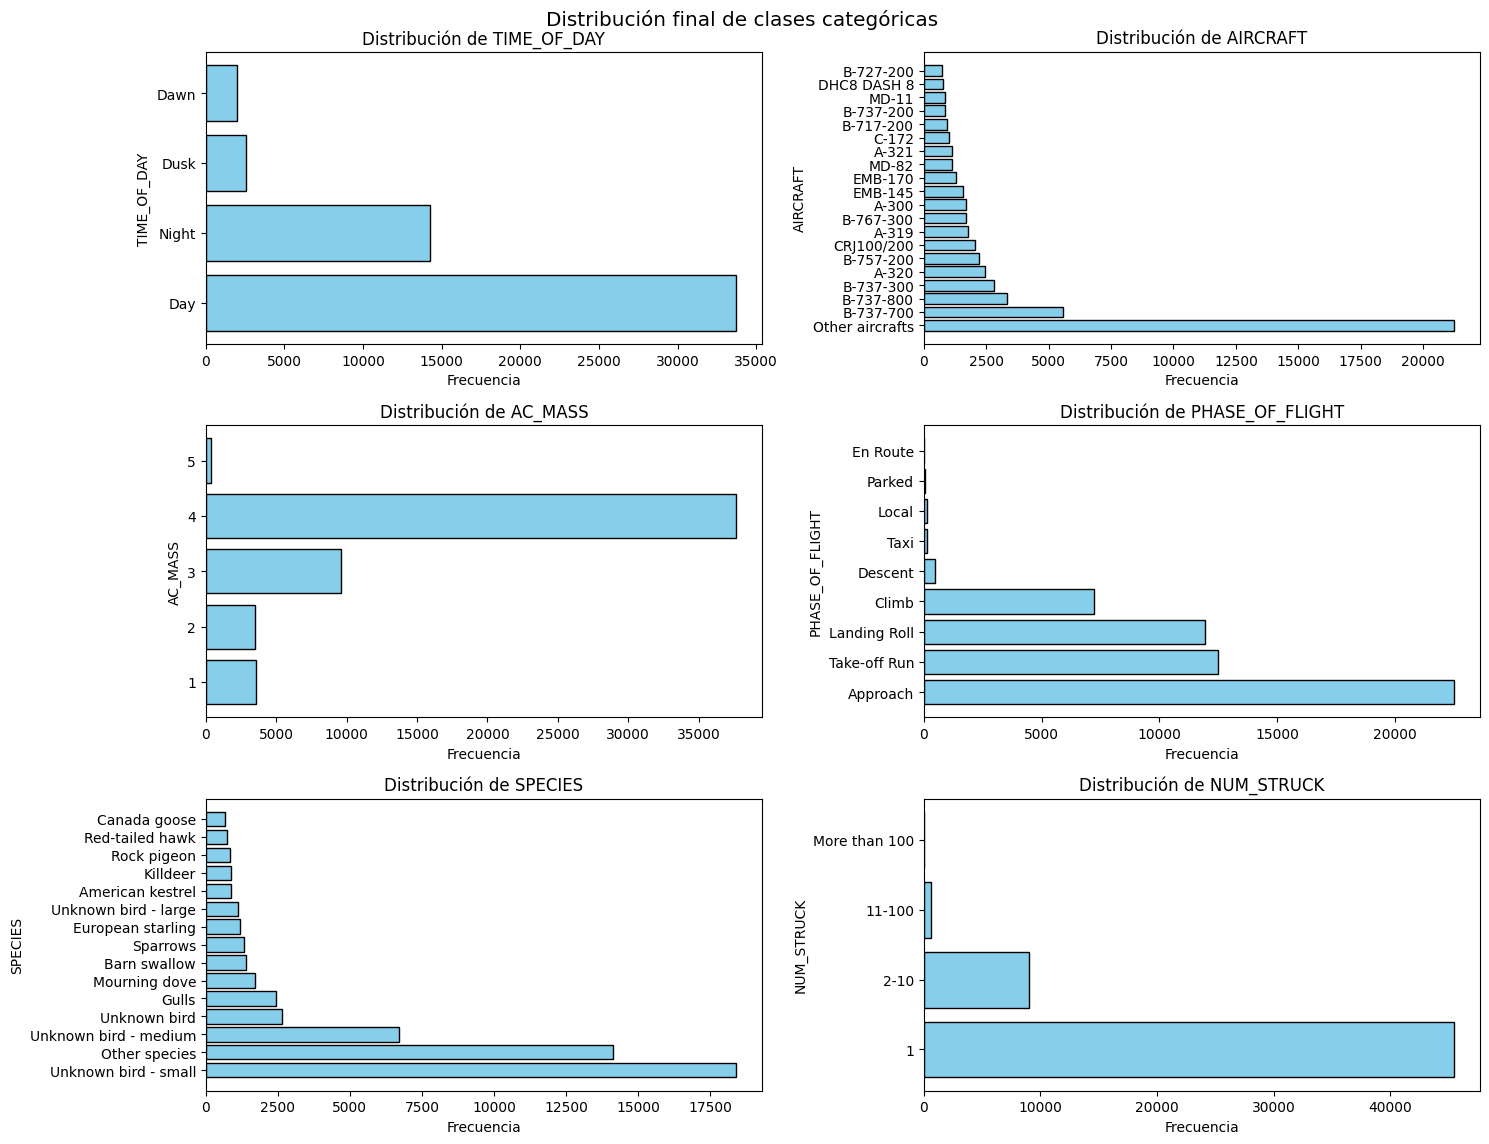

In [20]:

# * Análisis de la distribución de columnas categóricas 
plt.figure(figsize=(15, 15))
plt.suptitle("Distribución final de clases categóricas ", fontsize="x-large")
for i, column in enumerate(CATEGORICAL_COLUMNS, 1):
    # Calculate the frequencies of each category
    value_counts = df[column].value_counts()
    # Create a horizontal bar chart
    plt.subplot(4, 2, i)  # Adjust the grid dimensions as needed
    plt.barh(value_counts.index, value_counts, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel('Frecuencia')
    plt.ylabel(column)
    
plt.tight_layout()
plt.show()

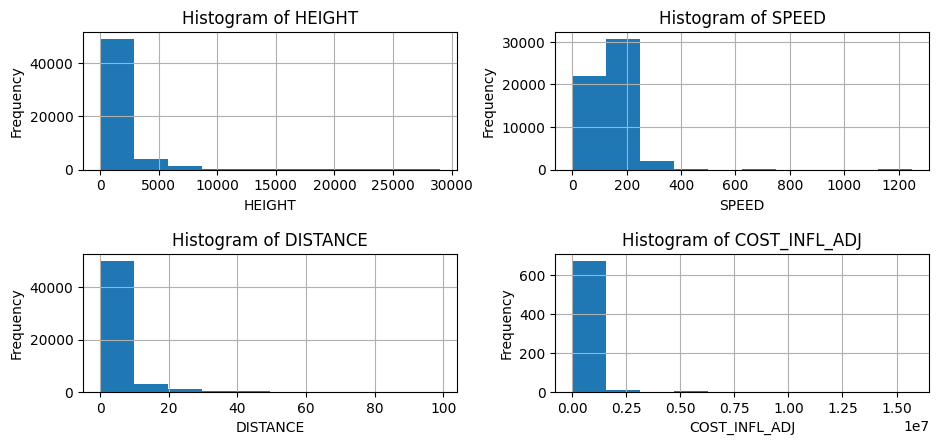

In [21]:
# Filter out 'INCIDENT_YEAR' from your columns list
num_cols = ['HEIGHT', 'SPEED', 'DISTANCE', 'COST_INFL_ADJ']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
fig.tight_layout(pad=4.0)

axes = axes.flatten()

# Iterate over each column and plot its histogram
for i, col in enumerate(num_cols):
    # Select the axis for plotting
    ax = axes[i]
    # Plot histogram
    df[col].hist(ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Display the plots
plt.show()


**On the topic of COST_INFL_ADJ:**

Due to the datasets nature, we're going to interpret that all COST_INFL_ADJ rows which are empty (aka: NaN), are those that where not filled in. Thus, we will replace the NaN's with 0. While this might prove to be innacurate, it will be a better solution for this project to maintain the large data volume intact. 

Deleting the NaN rows would make our data pass from over 54000 rows, to just above 1000.

In [22]:
df['COST_INFL_ADJ'] = df['COST_INFL_ADJ'].fillna(0)

----

# PCA

Para poder efectuar un Principal Component Analysis, deseamos intentar predecir el tipo de animal que tuvo un accidente junto a nuestro avión. Ya que es la información que más dificil tenemos la posibilidad de averiguar.

Con la información que tenemos sabiendo el tipo de avión, estado, año, y distancia, podremos observar los patrones con el fin de evitar dichos daños y evitar tener que gastar más dinero. 

In [23]:
df_pca = df # * We take a copy of the dataset for distinct modifications when it comes to clustering.  
df_pca.head()
#print(len(NUMERICAL_COLUMNS)) - 5
#print(len(CATEGORICAL_COLUMNS)) - 6

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_INFL_ADJ
0,Day,Other aircrafts,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,0.0
1,Day,Other aircrafts,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,0.0
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,0.0
3,Day,Other aircrafts,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,0.0
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,0.0


PCA should only be applied to the numerical variables. So we will only consider AC_MASS, NUM_STRUCK, INCIDENT_YEAR, HEIGHT, SPEED, DISTANCE, COST_INFL_ADJ. Moreover, we will change our output target column into labels. 

In [26]:
encoder = LabelEncoder()
df_pca['SPECIES_ENCODED'] = encoder.fit_transform(df['SPECIES'])
df_pca = df_pca.drop(columns=['SPECIES'])

In [29]:
X = df_pca[NUMERICAL_COLUMNS]
y = df_pca.SPECIES_ENCODED # * Continuous data for the darget

In [32]:
X.shape, y.shape

0    13
1    14
2    14
3     0
4    13
Name: SPECIES_ENCODED, dtype: int64

### Steps for PCA once the dataset has been prepared: 
+ Split the data into train and test datasets. 
+ Apply the Standard scaler. 
+ Find out the optimal number of dimensions to reduce the numerical data to using Scree Plots
+ Apply PCA. 
+ Visualise the information + Extract the eigenvectors

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [36]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [42]:
# Reconstruction error on MNIST vs number of latent dimensions used by PCA
# * This is dimension D
X_rank = np.linalg.matrix_rank(X_train) 

# * Generate the K's vector - To test out for the optimal L. 
Ks = [1,2,3,4,5]

# ? - Vectors which are intended to store the RMSE values for train and test datasets.
RMSE_train = np.arange(len(Ks))
RMSE_test = np.arange(len(Ks))

In [54]:

# * For each L which we want to test out perform a PCA and it's corresponding reconstruction 
# * Both for the train & test datasets - Then for that specific L, log what the RMS error is in order to plot it. 
for index, K in enumerate(Ks):
    print(K)
    pca = PCA(n_components=K)

    Xtrain_transformed = pca.fit_transform(X_train)
    print(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    print(Xtrain_proj)
    RMSE_train[index] = mean_squared_error(X_train, Xtrain_proj, squared=False)

    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test[index] = mean_squared_error(X_test, Xtest_proj, squared=False)

1
[[ 0.4609625  -0.43546328  0.34990822 -0.3895984  -0.02810872]
 [-0.70244423 -0.43546328 -0.19338197 -0.3895984  -0.02810872]
 [ 0.4609625  -0.03673921 -1.38862037 -0.0390907  -0.02810872]
 ...
 [ 1.04266587 -0.43546328  0.11086054 -0.3895984  -0.02810872]
 [-1.2841476  -0.40698299  0.34990822 -0.3895984  -0.02810872]
 [-2.44755434 -0.43546328 -0.73667215 -0.3895984  -0.02810872]]
[[-4.15533810e-02 -1.10116749e-01 -1.00248205e-01 -1.06818139e-01
   8.14423762e-04]
 [-1.62528930e-01 -4.30702797e-01 -3.92103678e-01 -4.17800848e-01
   3.18547900e-03]
 [-1.50914982e-01 -3.99925755e-01 -3.64084841e-01 -3.87945750e-01
   2.95785191e-03]
 ...
 [-4.13090459e-02 -1.09469260e-01 -9.96587431e-02 -1.06190045e-01
   8.09634927e-04]
 [-1.23193175e-01 -3.26462773e-01 -2.97205532e-01 -3.16683394e-01
   2.41451951e-03]
 [-3.11947870e-01 -8.26664031e-01 -7.52579294e-01 -8.01900837e-01
   6.11400930e-03]]
2
[[ 0.4609625  -0.43546328  0.34990822 -0.3895984  -0.02810872]
 [-0.70244423 -0.43546328 -0.1933

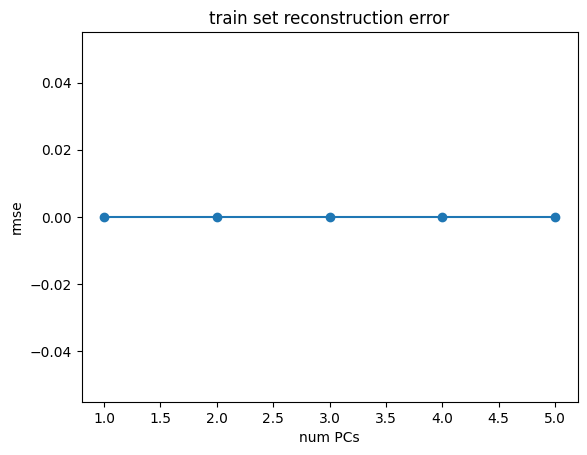

In [52]:
fig, ax = plt.subplots()
xs = Ks
ys = RMSE_train
plt.title("train set reconstruction error")
plt.xlabel("num PCs")
plt.ylabel("rmse")
ax.plot(xs, ys, marker="o")
plt.show()

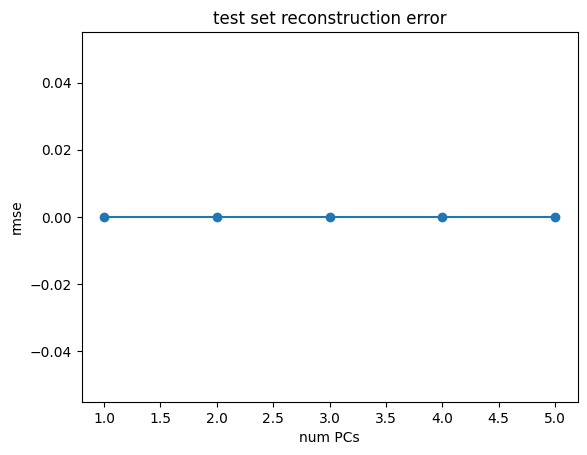

In [45]:
fig, ax = plt.subplots()
xs = Ks
ys = RMSE_test
plt.title("test set reconstruction error")
plt.xlabel("num PCs")
plt.ylabel("rmse")
ax.plot(xs, ys, marker="o")
plt.show()

In [46]:
# * Fraction of variance explained
pca = PCA(n_components=X_rank)
# ? - This is part of the Scree Plot which is mentioned in the slides.  
X_transformed = pca.fit_transform(X_train)
evals = pca.explained_variance_  # eigenvalues in descending order
# ? - We're limite the number of dimensions to 50 as a maximum
fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

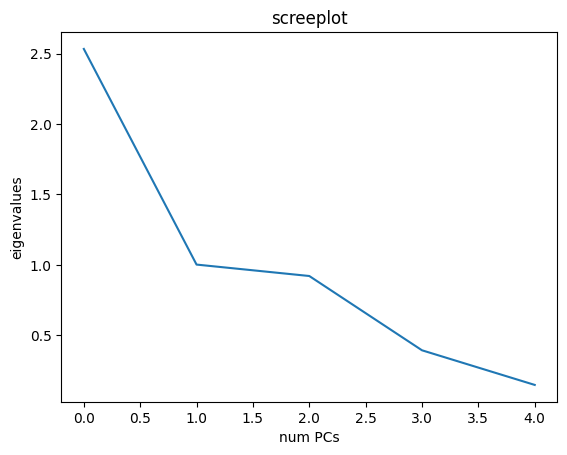

In [49]:
fig, ax = plt.subplots()
xs = np.arange(0, 5)
ys = evals[0:5]
plt.title("screeplot")
plt.xlabel("num PCs")
plt.ylabel("eigenvalues")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.plot(xs, ys)
plt.show()

In [55]:
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

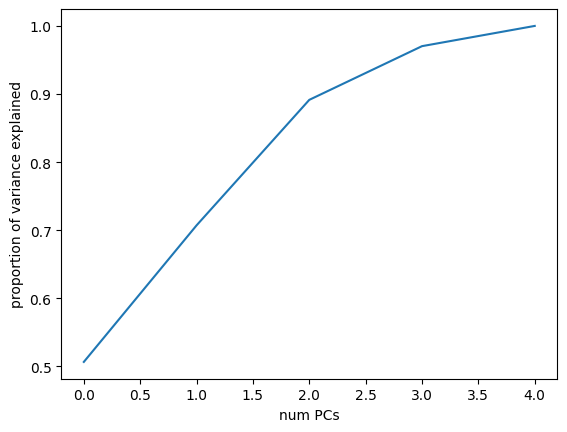

In [64]:
fig, ax = plt.subplots()
xs = np.arange(0, 5)
ys = fraction_var
plt.xlabel("num PCs")
plt.ylabel("proportion of variance explained")
ax.plot(xs, ys)
plt.show()

## Log likelihood

In [59]:
 # * Profile Likelihood
def log_likelihood(evals):
    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]  # Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        # eqn (20.30)
        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2  
    return ll

In [60]:
ll = log_likelihood(evals) # * Insert all of the corresponding eigenvalues. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



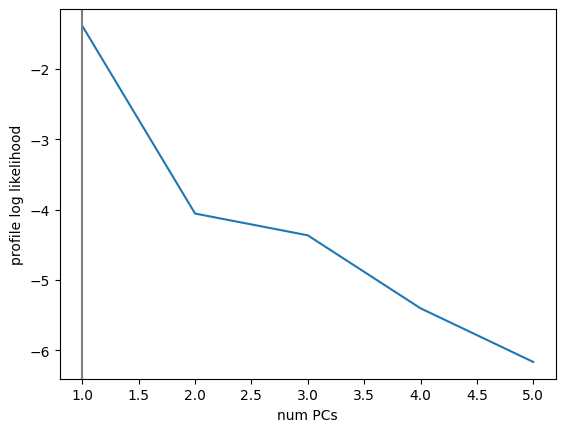

In [62]:
fig, ax = plt.subplots()
xs = np.arange(1, 6)
ys = ll[0:50]

plt.xlabel("num PCs")
plt.ylabel("profile log likelihood")
plt.plot(xs, ys)
idx = np.argmax(ys)
plt.axvline(xs[idx], c='grey')
plt.show()

----
# Clustering 